In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, RandomizedSearchCV, GridSearchCV, cross_val_predict, validation_curve
from scipy.stats import randint
from xgboost import XGBRegressor
import shap

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Introduction
Why do countries with similar size and resources follow such different economic paths? Decades of scholarship link stronger public health to faster growth, yet most models still rely on broad demographic or fiscal aggregates (Agu et al.; Mathers et al.). By shifting the lens to cause-specific death counts, our study tests whether seemingly non-economic hazards—unsafe water, polluted air, second-hand smoke—quietly forecast national prosperity. Formally, we ask: Can we predict a country’s GDP from counts of death due to *Unsafe water source*, *Unsafe sanitation*, *No access to handwashing facility*, *Household air pollution from solid fuels*, *Secondhand smoke*, *Air pollution*, and *Outdoor air pollution* from 1990-2009? Demonstrating that reducing these burdens boosts GDP provides health ministries with a powerful fiscal argument for investment.
A second puzzle concerns the base of the population pyramid. Child wasting—acute under-nutrition leading to dangerously low weight-for-height—remains stubbornly high in many regions, undercutting future labor productivity and straining health budgets (Hayes and Asres). Most nutrition studies track food availability or income but rarely link long-horizon dietary risk profiles to later wasting outcomes. We therefore ask: Can we predict a country’s 2009 child wasting rates based on dietary risk factors—including* Diet low in fruit*s,* Diet low in vegetable*s,* Diet high in sodiu*m,* Diet low in whole grain*s, and* Diet low in nuts and seed* —from the years 1990-2008? Answering this equips governments and NGOs with an evidence map of which dietary shortages matter most, sharpening the targeting of food-security subsidies and school-meal programs.
Together, these investigations draw on open global datasets on mortality (Kaggle; Mathers et al.), caloric intake (ChartsBin dataset), and macroeconomic outcomes (World Bank WITS database), and apply interpretable ensemble models (Kuhn and Johnson; Fatima et al.) to reveal levers that conventional growth and nutrition studies often overlook. By connecting cause-specific deaths and long-term diet patterns to economic and health end-points, the project bridges a gap between macro-econometric growth models and disease-burden analyses, translating insights into clear policy targets aligned with the UN Sustainable Development Goal.


## Data

In order to answer our research questions, we merged four different datasets. The first dataset used was a worldwide deaths by country and risk factors dataset from Kaggle, originally collected from the World Health Organization (WHO). It describes the total annual deaths attributed to specific risk factors for each country from 1990 to 2017. For our project, we limited the timeframe to 1990 to 2009. The population for this dataset consists of all countries with available records during that period. The original dataset includes 31 variables, of which we selected 13 relevant variables for our research. The second dataset contains annual population statistics for countries around the world. The sources for this dataset are the History Database of the Global Environment (HYDE), Gapminder, and the United Nations World Population Prospects (UN WPP). We again restricted our analysis to the years 1990 to 2009. This dataset provides the total national population for each country during those years. The third dataset comes from the World Integrated Trade Solution (WITS) and records the GDP in U.S. dollars for different countries between 1988 and 2022. For our analysis, we focused on GDP figures from 1990 to 2009. The population for this dataset consists of the countries for which GDP data is available during those years. The final dataset used is a caloric intake per capita dataset, which was scraped from ChartsBin and originally compiled by the Food and Agriculture Organization of the United Nations (FAO). This dataset reports the average daily caloric intake per person per day (kcal/person/day) for each country across four time intervals: 1990–1992, 1995–1997, 2000–2002, and 2005–2007. The population for this dataset is the set of countries included in the FAO records during those intervals. 

The datasets had different country names, which made it difficult to merge on the *Country* column. To account for these differences, we standardized the country names across the datasets. This allowed us to perform a join on the Country column, creating a dataset with 35 variables. After joining the datasets, we had a large number of rows. We filtered the dataset by removing observations for territories, regions, and small entities that are not widely recognized as independent countries. Additionally, we excluded countries with very small populations, as their data was often incomplete or unrepresentative. After this process, we had 1981 observations within our dataset. The only dataset with missing values was the daily caloric intake per capita dataset, as this groups the values into years 1990–92, 1995–97, 2000–02, and 2005–07. As a result, we were missing a significant amount of data for the years in between the groups. To handle this, we limited the use of daily caloric intake per capita to only the years available when creating the visualizations. However, as we progressed through this analysis, we focused less on daily caloric intake per capita and more on other variables.

Our final dataset has a total of 35 variables and 1981 observations. However, for our two models, we only used a selected subset of variables. For the first model, we looked at variables related to GDP and different environmental risks. For example, *GDP* is the annual GDP of the given country in US dollars. *Unsafe Water Source* is the total annual deaths caused by consuming untreated water. *Unsafe sanitation* refers to the total annual deaths caused by a lack of hygienic facilities. *No access to handwashing facilities* refers to the total annual deaths related to a lack of access to a handwashing facility. *Household air pollution from solid fuels* refers to the total annual deaths due to the pollution caused by the burning of solid fuels like wood, dung, or crop waste for cooking or heating. *Secondhand smoke* is the total annual deaths related to being exposed to smoke from tobacco products. Air pollution refers to the total annual deaths caused by air pollution. *Outdoor Air pollution* refers to the total annual deaths related to pollutants in the outside air, such as fine particulate matter. For our second model, we focused on variables related to child wasting and dietary risks. For instance, *Diet low in vegetables* refers to the total number of deaths related to consuming enough vegetables per day. *Diet low in nuts and seeds* refers to the total annual number of deaths related to not consuming enough nuts and seeds. *Diet high in sodium* is the total annual number of deaths caused by having excessive sodium within the diet. Diet low in whole grains covers the total annual number of deaths caused by consuming an insufficient amount of whole grains per day. Diet low in fruits refers to the total annual deaths related to consuming an inadequate amount of fruit per day. *Child wasting* is the total annual deaths that occur when a child’s weight is too low for their height. The table below states the specific thresholds for these variables.

| **Metric**                | **Description**                                                                                  |
|----------------------------|--------------------------------------------------------------------------------------------------|
| **Diet Low in Vegetables** | Total annual deaths related to consuming on average less than 280–320 grams of vegetables per day. |
| **Diet Low in Nuts/Seeds** | Total annual deaths related to not consuming on average less than 30 grams of nuts and seeds per day. |
| **Diet High in Sodium**    | Total annual deaths caused by consuming on average more than 2300 milligrams of sodium per day.  |
| **Diet Low in Whole Grains** | Total annual deaths caused by consuming on average less than 140–160 grams of whole grains per day. |
| **Diet Low in Fruits**     | Total annual deaths related to consuming on average less than 310–340 grams of fruit per day.     |
| **Child Wasting**          | Total annual deaths that occur when a child’s weight falls 2 standard deviations below the expected weight for their height. |

As our first question concerns environmental risk factors, it is insightful to examine the environmental progress of various countries. The figure below illustrates the yearly trends in air pollution death rates (per 100,000) for the top 5 countries with the highest air pollution-related mortality rates. It is interesting to note that in 1990, the country of Guinea started out with the highest air pollution death rates out of the 5 countries. However, it continued on a steady decline over the years, and in 2009, it was the country with the lowest air pollution death rates. This might suggest that some changes occurred in Guinea's environmental policies, leading to a steady decrease in air pollution-related death rates. Conversely, in 1990, North Korea had the lowest air pollution death rates among countries. However, over the course of 20 years, it became the highest country. This may suggest the waning importance placed on environmental regulations within North Korea. The figure shows that overall, countries have been lowering their air pollution death rates, but it still remains a problem to this day.


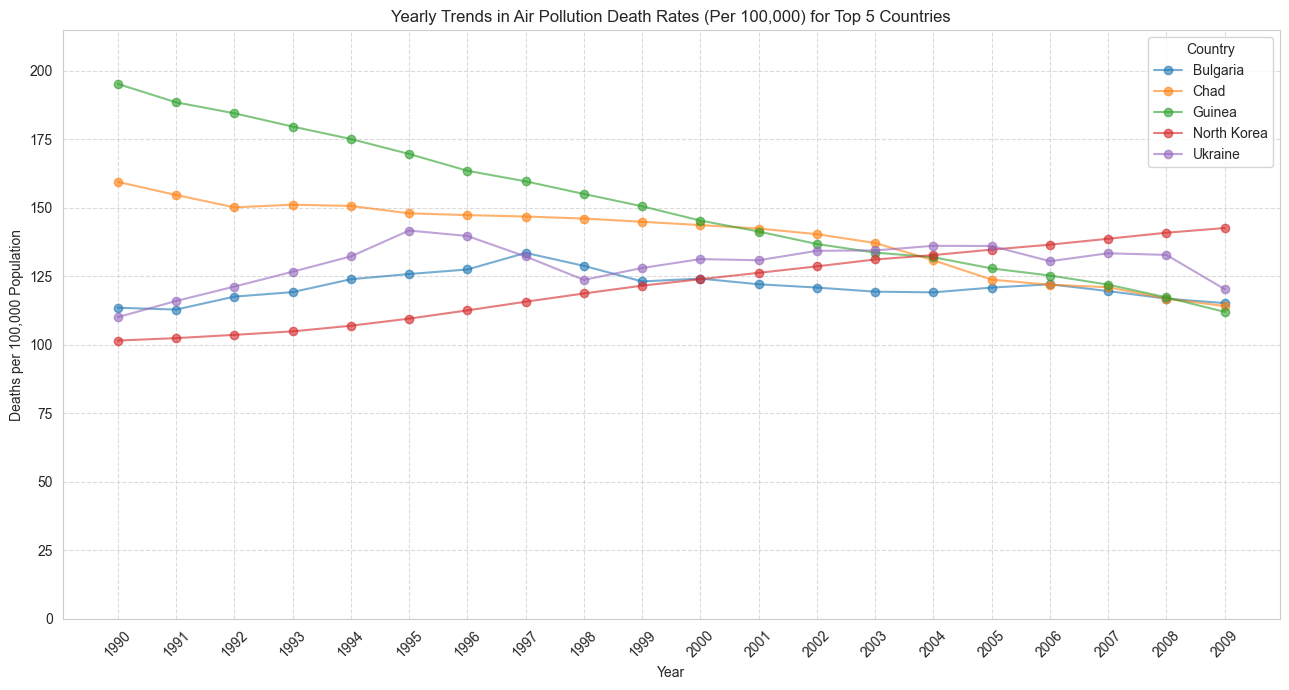

In [54]:
# Load data
df = pd.read_csv("merged.csv")

air_poll_col = "Air pollution"
population_col = "Population"

# Group and create deaths per 100k
grouped = df.groupby(["Country", "Year"], as_index=False)[[air_poll_col, population_col]].sum()
grouped["air_poll_rate_per_100k"] = (grouped[air_poll_col] / grouped[population_col]) * 100_000

# Find latest year and top 5 countries
latest_year = grouped["Year"].max()
latest_data = grouped[grouped["Year"] == latest_year].copy()
top_5_countries = latest_data.nlargest(5, "air_poll_rate_per_100k")["Country"].tolist()

# Prepare dataframe for plotting
top_5_df = grouped[grouped["Country"].isin(top_5_countries)].copy()
pivot_df = top_5_df.pivot(index="Year", columns="Country", values="air_poll_rate_per_100k")
pivot_df.sort_index(inplace=True)
pivot_df.index = pivot_df.index.astype(int)

# Plot
fig, ax = plt.subplots(figsize=(13, 7))
pivot_df.plot(marker="o", alpha=0.6, ax = ax)  # Add transparency

years = pivot_df.index
plt.xticks(years, years, rotation=45)

# Title and labels
plt.title("Yearly Trends in Air Pollution Death Rates (Per 100,000) for Top 5 Countries")
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000 Population")

# Make y-axis start at 0 and show full range
y_max = pivot_df.max().max() * 1.1  
plt.ylim(0, y_max)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Country", loc="best")
plt.tight_layout()
plt.show()

## Results

### **Question 1 – Predicting GDP from Environmental-Risk Deaths**

To answer our first research question, we followed a process that focused on exploring the relationships between death counts caused by environmental factors versus *GDP*. Early on, we decided to evaluate all models using Repeated K-Fold Cross-Validation (RKF CV) instead of the simpler K-Fold method since our initial K-Fold results varied significantly depending on how the data was split. RKF CV allowed us to average over many random partitions which provided a more stable and reliable estimate of model performance. This decision was supported by guidance from Applied Predictive Modeling by Kuhn and Johnson (70), which also recommended using 10 folds to reduce bias. As a result, every model, including the baseline model, was evaluated using RKF CV with 10 folds and 5 repeats. Before modeling, we divided the death counts by each country’s yearly population, so the predictors represent deaths per million people due to each environmental risk. We started by plotting each predictor against *GDP* and observed extremely nonlinear patterns, often resembling reciprocal curves. Additionally, a correlation matrix showed high correlations between *Unsafe water source*, *Unsafe sanitation*, and *No access to handwashing facility*, all above 0.99, so we dropped the latter two predictors to reduce redundancy and noise.

We first created a baseline model for model comparison that predicted the mean *GDP* for all observations and achieved a RKF CV mean R² of −0.0006 and an RMSE of 6.57e+11. Recognizing that strong nonlinear predictors could mislead simple models, we next trained a Random Forest Regressor, which performs well in capturing complex nonlinear relationships and is able to adapt to patterns without requiring any specific form of the relationship between predictors and the target. On the initial train-test split, Random Forest performed well with a training R² of 0.9815, a test R² of 0.8364, and a test RMSE of 2.66e+11. However, its 5-Fold CV mean R² dropped drastically to −0.0109, indicating that the model was sensitive to the data split which could have been unlucky. Switching to RKF CV improved the mean R² to 0.8876 with a standard deviation of 0.0984. To see if tuning the hyperparameters could further improve the model, we performed a Grid Search across 243 candidate models, with the best tuned model having a slightly improved RKF CV mean R² of 0.8932 with a reduced standard deviation of 0.0770. Although tuning helped minorly, the Random Forest residuals showed a strong fanning pattern, so we applied a log transformation to *GDP* to compress the range and stabilize variance.

After retraining Random Forest on the log-transformed target, the RKF CV mean R² improved to 0.9371 with a smaller standard deviation of 0.0169. We also tested reciprocal transformations (1/x) on predictors to better linearize the decaying relationships seen in the scatterplots, but the model's RKF CV mean R² only reached 0.8877, so we continued using the log-transformed target. To explore additional improvements, we trained an XGBoost Regressor, which builds trees sequentially and corrects previous errors, outperforming Random Forest in a 2023 study (Sana et al. 31). After tuning, XGBoost achieved a larger RKF CV mean R² of 0.9416 with a smaller standard deviation of 0.0145. We also log-transformed predictors to further linearize the relationships and fit a Linear Regression model, but it only achieved a RKF CV mean R² of 0.5441. Although the scatterplots between log-transformed predictors and log-transformed *GDP* looked approximately linear, there was some slight curvature and spread, which could indicate potential nonlinear interactions when considering multiple features together. We therefore tested polynomial regression models of different degrees and found that a 6th-degree polynomial resulted in the best RKF CV mean R² of 0.9619 and a standard deviation of 0.0261.


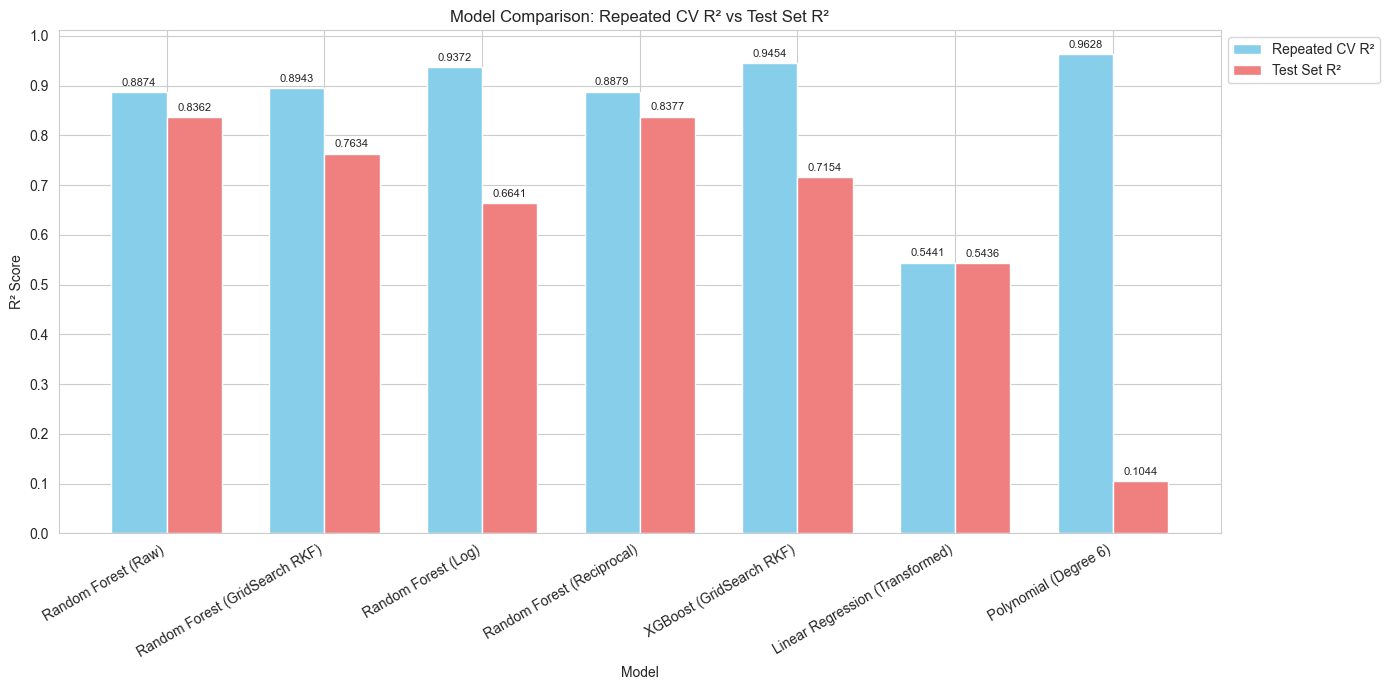

In [62]:
# Labels for the models
labels = [
    "Random Forest (Raw)",
    "Random Forest (GridSearch RKF)",
    "Random Forest (Log)",
    "Random Forest (Reciprocal)",
    "XGBoost (GridSearch RKF)",
    "Linear Regression (Transformed)",
    "Polynomial (Degree 6)"
]

# Repeated CV R² (means)
r2_means_rkf = [
    rep_scores.mean(), 
    rep_scores_grid_rf.mean(),
    rep_scores_log.mean(),    
    rep_scores_recip.mean(),
    rep_scores_grid_xgb.mean(),
    rep_scores_lr.mean(),
    rep_scores_poly.mean()
]

# Test set R² values (your provided ones)
r2_means_test = [
    test_r2,        # random forest raw
    rf_test_r2,     # random forest gridsearch rkf
    test_r2_actual, # random forest log
    test_r2_recip,  # random forest reciprocal
    test_r2_actual_grid, # xgboost gridsearch rkf
    test_r2_lr,     # linear regression transformed
    test_r2_poly    # polynomial degree 6
]

# X-axis positions
x = np.arange(len(labels))
width = 0.35  # Width of each bar

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

bars1 = ax.bar(x - width/2, r2_means_rkf, width, label='Repeated CV R²', color='skyblue')
bars2 = ax.bar(x + width/2, r2_means_test, width, label='Test Set R²', color='lightcoral')

ax.set_ylabel("R² Score")
ax.set_xlabel("Model")
ax.set_title("Model Comparison: Repeated CV R² vs Test Set R²")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha='right')
ax.set_yticks(np.arange(0, 1.05, 0.1))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add actual values to the plot
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [55]:
# Environmental factors
death_cols = [
    "Unsafe water source",
    "Unsafe sanitation",
    "No access to handwashing facility",
    "Household air pollution from solid fuels",
    "Secondhand smoke",
    "Air pollution",
    "Outdoor air pollution"
]

# Divide each predictor by population (deaths per million)
for col in death_cols:
    df[col] = df[col] * 1000000 / df['Population']

# Only keep necessary columns and drop nulls
df = df.drop(columns=['Population'])

df = df[death_cols + ['GDP']].dropna()

# Check plots of target vs predictor
num_features = len(death_cols)
cols = 2
rows = (num_features + 1) // cols

# Remove the highly correlated predictors
death_cols = [
    "Unsafe water source",
    "Household air pollution from solid fuels",
    "Secondhand smoke",
    "Air pollution",
    "Outdoor air pollution"
]

X = df[death_cols]
y = df['GDP']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Baseline model
bl_prediction = np.mean(y_train)

y_pred_bl = np.full_like(y_test, fill_value=bl_prediction)

baseline_r2 = r2_score(y_test, y_pred_bl)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_bl))

baseline_r2_scores = []

# Define the RKF CV
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Loop over each train-test split
for train_index, test_index in rkf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Compute mean GDP in training fold
    y_train_mean = y_train_fold.mean()
    
    # Predict the mean for every observation in test fold
    y_pred_fold = np.full_like(y_test_fold, fill_value=y_train_mean, dtype=np.float64)
    
    # Calculate R-squared for this fold
    r2 = r2_score(y_test_fold, y_pred_fold)
    baseline_r2_scores.append(r2)

baseline_r2_scores = np.array(baseline_r2_scores)

# Basic Random Forest Regression

# Fit and Train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred_train = rf.predict(X_train)
rf_pred = rf.predict(X_test)

# Calculate R-squared
train_r2 = r2_score(y_train, rf_pred_train)
test_r2 = r2_score(y_test, rf_pred)
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

# Repeated K-Fold Cross Validation (for more robust testing - less luck based)
rep_scores = cross_val_score(RandomForestRegressor(random_state=42), X, y, cv=rkf, scoring='r2')

# Residual Plot
residuals = y_test - rf_pred

# Grid search hyperparameters
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

rf = RandomForestRegressor(random_state=42)

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1, # make it faster
    verbose=0
)

rf_grid.fit(X_train, y_train)

# Evaluate on test set
rf_test_r2 = rf_grid.best_estimator_.score(X_test, y_test)

best_rf = rf_grid.best_estimator_

rep_scores_grid_rf = cross_val_score(best_rf, X, y, cv=rkf, scoring='r2', n_jobs=-1)

# Log transform the target
y_log = np.log1p(y)

# Train-test split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=42)

# Train model
rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_train_log, y_train_log)

rf_train_pred_log = rf_log.predict(X_train_log)
rf_test_pred_log = rf_log.predict(X_test_log)

# Convert predictions and true values back to original GDP units
y_train_actual = np.expm1(y_train_log) 
y_test_actual = np.expm1(y_test_log)
rf_train_pred_actual = np.expm1(rf_train_pred_log) 
rf_test_pred_actual = np.expm1(rf_test_pred_log) 

# Calculate R-squared in original units
train_r2_actual = r2_score(y_train_actual, rf_train_pred_actual)
test_r2_actual = r2_score(y_test_actual, rf_test_pred_actual)

# Repeated K-Fold Cross Validation (for more robust testing - less luck based)
rep_scores_log = cross_val_score(RandomForestRegressor(random_state=42), X, y_log, cv=rkf, scoring='r2')

# Residual Plot
residuals = y_test_actual - rf_test_pred_actual

X_recip = pd.DataFrame()

# Create reciprocal predictors
for col in death_cols:
    X_recip[f"{col}_inv"] = 1 / (X[col] + 1)

# Split the data
X_train_recip, X_test_recip, y_train_recip, y_test_recip = train_test_split(X_recip, y, test_size=0.3, random_state=42)

rf_recip = RandomForestRegressor(n_estimators=100, random_state=42)
rf_recip.fit(X_train_recip, y_train_recip)

y_pred_recip = rf_recip.predict(X_test_recip)
y_pred_train_recip = rf_recip.predict(X_train_recip)

# Calculate R-squared
train_r2_recip = r2_score(y_train_recip, y_pred_train_recip)
test_r2_recip = r2_score(y_test_recip, y_pred_recip)
rmse_recip = np.sqrt(mean_squared_error(y_test_recip, y_pred_recip))

# Repeated K-Fold Cross Validation (for more robust testing - less luck based)
rep_scores_recip = cross_val_score(RandomForestRegressor(random_state=42), X_recip, y, cv=rkf, scoring='r2')

# Residuals Plot
residuals = y_test_recip - y_pred_recip

In [56]:
# Evaluate on test set
best_xgb = xgb_grid.best_estimator_

rep_scores_grid_xgb = cross_val_score(best_xgb, X, y_log, cv=rkf, scoring='r2', n_jobs=-1)

In [57]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# XGB grid search hyperparameters
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

xgb_grid.fit(X_train_log, y_train_log)

y_train_pred_log = best_xgb.predict(X_train_log)
y_test_pred_log = best_xgb.predict(X_test_log)

# Revert to original units
y_train_actual_grid = np.expm1(y_train_log)
y_test_actual_grid = np.expm1(y_test_log)
y_train_pred_actual_grid = np.expm1(y_train_pred_log)
y_test_pred_actual_grid = np.expm1(y_test_pred_log)

# Calculate R-squared in original units
train_r2_actual_grid = r2_score(y_train_actual_grid, y_train_pred_actual_grid)
test_r2_actual_grid = r2_score(y_test_actual_grid, y_test_pred_actual_grid)


rmse_xgb = np.sqrt(mean_squared_error(y_test_actual_grid, y_test_pred_actual_grid))

# Calculate residuals
residuals = y_test_actual_grid - y_test_pred_actual_grid


When deciding on the best model, we prioritized RKF CV performance over test set performance to get a more stable estimate of generalization. After evaluating all models, we selected the tuned XGBoost Regressor as the best model for this project. While the 6th-degree Polynomial Regression achieved the highest RKF CV mean R² of 0.9619, it performed much worse on the test set with an R² of only 0.6494, suggesting overfitting to the training data. Polynomial models often struggle to generalize when making predictions on new or unseen data, especially when input values fall outside the range of the training data. In contrast, Random Forest and XGBoost split the feature space into smaller regions based on decision rules, and make predictions by averaging or adjusting outcomes within those regions, which helps the models remain stable even when encountering new data that is slightly different from the training set. Furthermore, Random Forest averages over many trees, while XGBoost builds trees sequentially to correct errors and includes regularization techniques like shrinkage and subsampling. As a result, the tuned XGBoost model achieved a RKF CV mean R² of 0.9416 and maintained a stronger test R² of 0.6978, which outperforms both Random Forest and Polynomial Regression and offers the most reliable generalization to new cases. Though XGBoost does not require assumptions like linearity, normality, or constant variance, we addressed outliers and multicollinearity to improve model performance and stability.
We used SHAP values to better understand how the XGBoost model made predictions. SHAP measures how much each feature contributes to the prediction, accounting for feature interactions, and shows whether a feature increases or decreases the output (Ergün 20). From the mean absolute SHAP values, *Household air pollution from solid fuels* and *Unsafe water source* were the most influential predictors as they each had values around 0.71. The SHAP summary plot showed that higher levels of *Household air pollution* generally pushed *GDP* predictions lower, while higher levels of *Outdoor air pollution* pushed *GDP* predictions higher. However, features like *Unsafe water source* and *Secondhand smoke* had less consistent effects. Although XGBoost performed strongly, it still has limitations: it may not generalize well if patterns between GDP levels or amounts of death caused by environmental factors change drastically, its complex structure makes it difficult to translate results into clear policy actions, and it cannot account for missing factors like political stability or economic shocks. Additionally, SHAP analysis shows influence at an observational level but does not establish true causality. Despite these challenges, XGBoost improved test R² from −0.0006 to 0.6978 and lowered test RMSE from 6.57e+11 to 3.61e+11, showing that our approach successfully captured meaningful relationships between counts of deaths caused by environmental factors and *GDP*.


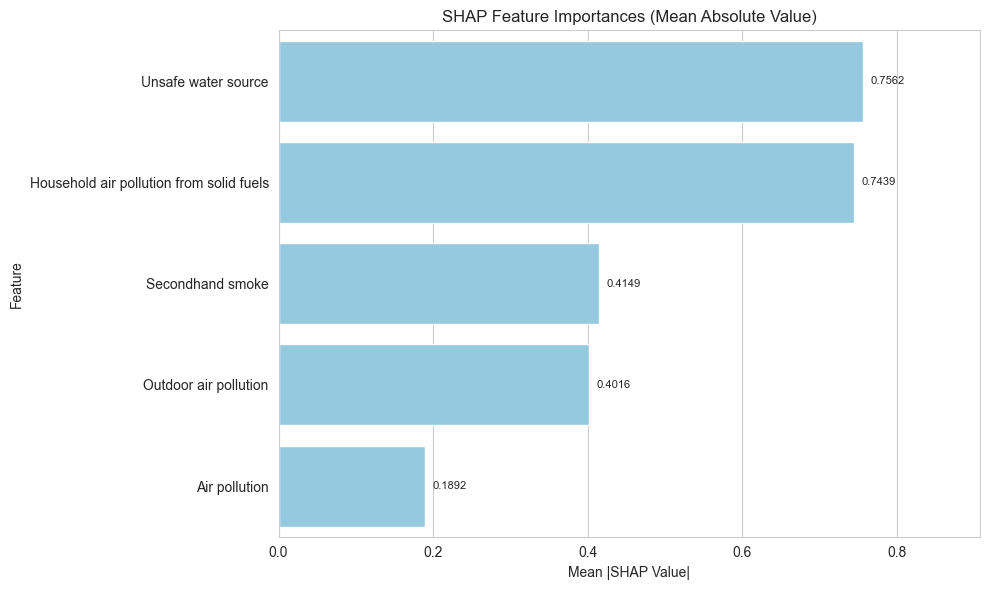

In [58]:
# Define SHAP
explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

shap_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean_Absolute_SHAP': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Mean_Absolute_SHAP', y='Feature', data=shap_df, color='skyblue')

# Add the actual value in the plot
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.01,  # offset numbers
             bar.get_y() + bar.get_height()/2,
             f'{width:.4f}',
             ha='left', va='center', fontsize=8)

# Leave space for labels
max_shap = shap_df['Mean_Absolute_SHAP'].max()
plt.xlim(0, max_shap * 1.2)  

plt.title('SHAP Feature Importances (Mean Absolute Value)')
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [61]:
X_trans = pd.DataFrame()

# Transform the predictors
for col in death_cols:
    X_trans[f"{col}_log"] = np.log1p(X[col])

df_trans = X_trans.copy()
df_trans['GDP'] = y_log.values

trans_cols = X_trans.columns.tolist()

# Plot target vs predictor
num_features = len(trans_cols)
cols = 2
rows = (num_features + 1) // cols

# Split the data
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans, y_log, test_size=0.3, random_state=42)

# Train linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_trans, y_train_trans)

y_pred_lr = lin_reg.predict(X_test_trans)
y_pred_train_lr = lin_reg.predict(X_train_trans)

# Calculate R-squared
train_r2_lr = r2_score(y_train_trans, y_pred_train_lr)
test_r2_lr = r2_score(y_test_trans, y_pred_lr)

# Repeated K-Fold Cross Validation (for more robust testing - less luck based)
rep_scores_lr = cross_val_score(LinearRegression(), X_trans, y_log, cv=rkf, scoring='r2')

# Residuals Plot
residuals = y_test_trans - y_pred_lr

# Degrees to try for polynomial regression
degrees = np.arange(1, 8)

model = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())

train_scores, val_scores = validation_curve(
    model,
    X_trans,
    y_log,
    param_name="polynomialfeatures__degree",
    param_range=degrees,
    cv=rkf,
    scoring='r2',
    n_jobs=-1
)

# Compute the means across all folds and repeats
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

poly_pipeline = make_pipeline(PolynomialFeatures(degree=6, include_bias=False), LinearRegression())

# Repeated CV
rep_scores_poly = cross_val_score(poly_pipeline, X_trans, y_log, cv=rkf, scoring='r2')

# Calculate model performance statistics using 6th-degree
poly_pipeline.fit(X_train_trans, y_train_trans)
y_train_pred_poly = poly_pipeline.predict(X_train_trans)
y_test_pred_poly = poly_pipeline.predict(X_test_trans)

y_train_actual_poly = np.expm1(y_train_trans)
y_test_actual_poly = np.expm1(y_test_trans)
y_train_pred_actual_poly = np.expm1(y_train_pred_poly)
y_test_pred_actual_poly = np.expm1(y_test_pred_poly)

train_r2_poly = r2_score(y_train_actual_poly, y_train_pred_actual_poly)
test_r2_poly = r2_score(y_test_actual_poly, y_test_pred_actual_poly)
train_rmse_poly = np.sqrt(mean_squared_error(y_train_actual_poly, y_train_pred_actual_poly))
test_rmse_poly = np.sqrt(mean_squared_error(y_test_actual_poly, y_test_pred_actual_poly))

residuals = y_test_actual_poly - y_test_pred_actual_poly

### **Question 2 – Predicting 2009 Child Wasting from Dietary Risk Factors**

When trying to predict a country’s child wasting rates in 2009 based on dietary risk factor statistics from 1990 to 2009, we started by finding how the death counts compare to the number of people living in each country. So, for each of the dietary risk factor variables, we divided them all by the total population of the country for that value. This helped us see if the total number of deaths was significant or not compared to the population. Then, we wanted to make sure we could use all 6 variables in our analysis. First, we created a correlation matrix that showed how much correlation existed between each variable. The map showed *Diet low in fruits (by Pop)* to be highly correlated with *Diet low in whole grains (by Pop)* and *Diet low in nuts and seeds (by Pop)*. The whole grain and nuts and seeds variables were also highly correlated with each other. After seeing this, we created a base Random Forest Regression model using the data from 1990-2008 so we could run a feature importance test. This test showed *Diet low in nuts and seeds (by Pop)* to be the most important feature, with the other two highly correlated variables being significantly less important. So, we decided to eliminate *Diet low in whole grains (by Pop)* and *Diet low in fruits (by Pop)* from our model to prevent multicollinearity. Once this was done, we defined our X as *Diet low in vegetables (by Pop)*, *Diet high in sodium (by Pop)*, and *Diet low in nuts and seeds (by Pop)* and our y as *Child wasting (by Pop)*. The training data for each is the data from the years 1990-2008 and the testing data for each is the data from the year 2009.

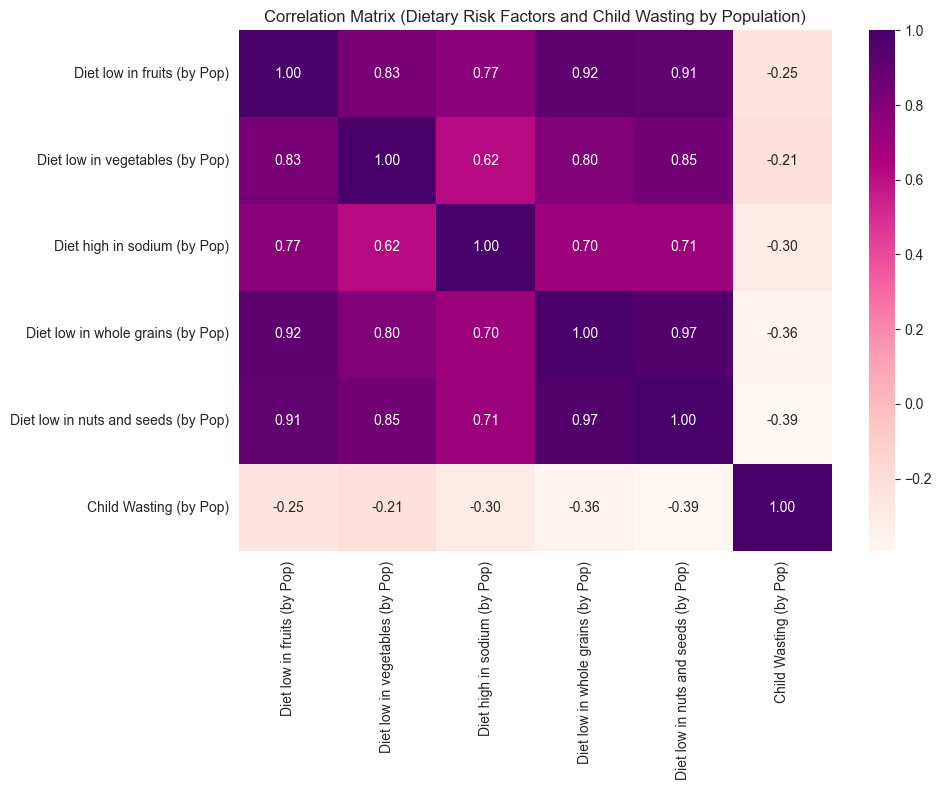

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import statsmodels.api as sm
from scipy.stats import zscore
from sklearn.model_selection import RepeatedKFold

# Import merged dataset.
df = pd.read_csv('merged.csv')
# Divide risk factors by their populations to create new variables.
df['Child Wasting (by Pop)'] = df['Child wasting'] / df['Population']
df['Diet low in fruits (by Pop)'] = df['Diet low in fruits'] / df['Population']
df['Diet low in vegetables (by Pop)'] = df['Diet low in vegetables'] / df['Population']
df['Diet high in sodium (by Pop)'] = df['Diet high in sodium'] / df['Population']
df['Diet low in whole grains (by Pop)'] = df['Diet low in whole grains'] / df['Population']
df['Diet low in nuts and seeds (by Pop)'] = df['Diet low in nuts and seeds'] / df['Population']
# Use heatmap to see which variables have high correlation.
plt.figure(figsize = (10, 8))
sns.heatmap(df[['Diet low in fruits (by Pop)', 'Diet low in vegetables (by Pop)', 
        'Diet high in sodium (by Pop)', 'Diet low in whole grains (by Pop)', 
        'Diet low in nuts and seeds (by Pop)', 'Child Wasting (by Pop)']].corr(), 
            annot = True, cmap = 'RdPu', fmt = ".2f")
plt.title("Correlation Matrix (Dietary Risk Factors and Child Wasting by Population)")
plt.tight_layout()
plt.show()


Once this initial testing and defining was done, we then started determining which model type would be most effective. We started by checking the assumptions for a linear regression model. To test for linearity, we made 3 subplots that compared *Child Wasting (by Pop)* to the 3 independent variables. All three plots did not show linearity, so the linear regression model was not used. Then, we tried using a support vector machine. After creating a basic subplot with the data, the model came back with a test RMSE of .0028 and a test R^2 score of -28.2779. Both of these results indicated that the model was very poor at making any kind of predictions with our data. So, we ran a grid search test to find the most optimal parameters and remade the model with those. This resulted in the same test RMSE and test R^2 score, so we decided this model would not do a good job of answering our question.

After the two failed model attempts, we tried using a Random Forest regression model. We first attempted to make a model with the default parameters. It resulted in a model that had a very high training R^2 and a moderate testing R^2. This showed that the model was overfitted. We then attempted to find the cross-validated mean R^2 scores with cross_val_score. The results from this were very low, reinforcing the idea that this model would not be efficient in its current state. After this, we used GridSearchCV to find the optimal parameters for the model. After applying them, the model showed lower scores for both training and testing R^2 scores, but the significant gap between the two models still implied overfitting. After this, we continuously reran the model, tweaking the number of estimators, the maximum depth, the minimum sample leaf, and the maximum sample split each time to try and create a model with more optimal results. After finding one that didn’t appear as overfit, we ran another cross-validated mean R^2 score test, but the result was significantly lower than before, showing poor generalization abilities. Once we saw these results, we tried seeing what would happen if we ran the model using the reciprocals of our X values in an attempt to standardize them, but this did not yield significantly different results. We then attempted to remove the outliers in the data we had by taking out values that were 2.5 standard deviations away from the mean. This resulted in our best outcomes, but the cross-validated mean R^2 score was still too low, so we paired the outlier removal with a StandardScaler on the data. This had better results than the previous model, but the mean R^2 score still needed improvement. We started to think that maybe the issue was with the way we were checking the data, so we found new methods of checking for accuracy. We tried using RepeatedKFold to check for mean R^2 scores, as this method tests the data on many splits, making it more reliable (Kuhn et al., 70). This test came out with significantly better results, so this was the final model and method chosen.

In [64]:
# Set X, y, and training and testing sets.
X = df[['Diet low in fruits (by Pop)', 'Diet low in vegetables (by Pop)', 
        'Diet high in sodium (by Pop)', 'Diet low in whole grains (by Pop)', 
        'Diet low in nuts and seeds (by Pop)']]
y = df['Child Wasting (by Pop)']

# Ensure testing data is for years before 2009 and training data is for 2009
test_df = df[df['Year'] == 2009]
train_df = df[df['Year'] != 2009]

X_train = train_df[['Diet low in fruits (by Pop)', 'Diet low in vegetables (by Pop)', 
        'Diet high in sodium (by Pop)', 'Diet low in whole grains (by Pop)', 
        'Diet low in nuts and seeds (by Pop)']]
y_train = train_df['Child Wasting (by Pop)']

X_test = test_df[['Diet low in fruits (by Pop)', 'Diet low in vegetables (by Pop)', 
        'Diet high in sodium (by Pop)', 'Diet low in whole grains (by Pop)', 
        'Diet low in nuts and seeds (by Pop)']]
y_test = test_df['Child Wasting (by Pop)']

# Create a base Random Forest Regressor so we can create a feature importance model.
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_regressor.fit(X_train, y_train)

# Test for feature importance.
feature_names = X.columns
importances = rf_regressor.feature_importances_


# Create New X and y that don't include fruit and whole grain.
X = df[['Diet low in vegetables (by Pop)', 'Diet high in sodium (by Pop)', 
        'Diet low in nuts and seeds (by Pop)']]
y = df['Child Wasting (by Pop)']

X_train = train_df[['Diet low in vegetables (by Pop)', 'Diet high in sodium (by Pop)',  
                    'Diet low in nuts and seeds (by Pop)']]
y_train = train_df['Child Wasting (by Pop)']

X_test = test_df[['Diet low in vegetables (by Pop)', 'Diet high in sodium (by Pop)', 
                  'Diet low in nuts and seeds (by Pop)']]
y_test = test_df['Child Wasting (by Pop)']


# Check assumptions for Linear Regression
# Linearity

features = ['Diet low in vegetables (by Pop)', 
            'Diet high in sodium (by Pop)', 
            'Diet low in nuts and seeds (by Pop)']


# Try an SVM model.
# Scale data to the standard scaler.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set SVM and y_pred.
svr = SVR(kernel = 'rbf')
svr.fit(X_train_scaled, y_train)

y_pred_svm = svr.predict(X_test_scaled)

# Evaluate performance.
rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2 = r2_score(y_test, y_pred_svm)


# Use gridsearch to try to find a better model.
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'linear', 'poly'],}

grid_search = GridSearchCV(SVR(), param_grid, cv = 5, scoring='r2', n_jobs = -1, verbose = 0)
grid_search.fit(X_train_scaled, y_train)


# Try again with new parameters.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR(kernel = 'rbf', C = .1, epsilon = 0.1)
svr.fit(X_train_scaled, y_train)

y_pred_svm = svr.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2 = r2_score(y_test, y_pred_svm)


# Try a random forest model with default variables.
rf_regressor = RandomForestRegressor(random_state = 42)
rf_regressor.fit(X_train, y_train)

# Predict on the test and training set.
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Calculate R squared and RMSE.
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Test Random Forest Regressor for optimal parameters.
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    scoring = 'r2')

grid_search.fit(X_train, y_train)

# Test model with best parameters.
param_grid = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt'}

# Initialize and train the model
rf_regressor = RandomForestRegressor(**param_grid, random_state = 42)
rf_regressor.fit(X_train, y_train)

# Predicting on the test and training set
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Calculate R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calculate RMSE.
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))


# Check for cross validated R Squared Scores.
scores = cross_val_score(rf_regressor, X_train, y_train, cv = 5, scoring = 'r2')


# Still slightly overfit, retrying with new parameters.
param_grid = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'sqrt'}

rf_regressor = RandomForestRegressor(**param_grid, random_state = 42)
rf_regressor.fit(X_train, y_train)

y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Still overfit, retrying with new parameters.
param_grid = {
    'n_estimators': 100,
    'max_depth': 19,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'}

rf_regressor = RandomForestRegressor(**param_grid, random_state = 42)
rf_regressor.fit(X_train, y_train)

y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Try another cross validated R squared mean test.
scores = cross_val_score(rf_regressor, X_train, y_train, cv = 5, scoring = 'r2')

param_grid = {
    'n_estimators': 100,
    'max_depth': 19,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'}

# Try model with reciprocols.
X_train_rec = 1 / (X_train.replace(0, 1e-6))
X_test_rec = 1 / (X_test.replace(0, 1e-6))

# Train on reciprocal features
rf_regressor = RandomForestRegressor(**param_grid, random_state = 42)
rf_regressor.fit(X_train_rec, y_train)

y_train_pred = rf_regressor.predict(X_train_rec)
y_test_pred = rf_regressor.predict(X_test_rec)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Check Cross Validation Score.
scores = cross_val_score(rf_regressor, X_train_rec, y_train, cv=5, scoring='r2')

# Compute Z-scores on the training results.
z_scores = np.abs(zscore(y_train))

# Create a mask for non-outliers.
mask = z_scores < 2.5

# Apply mask to training data.
X_train_cleaned = X_train[mask]
y_train_cleaned = y_train[mask]

# Complete rest of Random Forest Regressor the same as before.
param_grid = {
    'n_estimators': 100,
    'max_depth': 19,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'
}

rf_regressor = RandomForestRegressor(**param_grid, random_state = 42)
rf_regressor.fit(X_train_cleaned, y_train_cleaned)

y_train_pred = rf_regressor.predict(X_train_cleaned)
y_test_pred = rf_regressor.predict(X_test)

r2_train = r2_score(y_train_cleaned, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Check Cross-Validated scores again.
scores = cross_val_score(rf_regressor, X_train_cleaned, y_train_cleaned, cv = 5, scoring = 'r2')

# Check optimal parameters again.
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    scoring = 'r2')

grid_search.fit(X_train_rec, y_train)

# Run Random Forest Regressor again without outliers and with features standardized.
z_scores = np.abs(zscore(y_train))

mask = z_scores < 2.5

X_train_cleaned = X_train[mask]
y_train_cleaned = y_train[mask]

# Standardize the features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': 50,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt'
}

rf_regressor = RandomForestRegressor(**param_grid, random_state = 42)
rf_regressor.fit(X_train_scaled, y_train_cleaned)

y_train_pred = rf_regressor.predict(X_train_scaled)
y_test_pred = rf_regressor.predict(X_test_scaled)

r2_train = r2_score(y_train_cleaned, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))


# Check Cross-Validated scores again.
scores = cross_val_score(rf_regressor, X_train_cleaned, y_train_cleaned, cv = 5, scoring = 'r2')

# Try RepeatedKFold cross-validation.
rkf = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state = 42)
rep_scores = cross_val_score(rf_regressor, X_train_cleaned, y_train_cleaned, 
                             cv = rkf, scoring = 'r2')

# Create baseline model for comparison.
# Set y bassline data.
mean_y_train = np.mean(y_train_cleaned)
y_train_pred_baseline = np.full_like(y_train_cleaned, mean_y_train, dtype = np.float64)
y_test_pred_baseline = np.full_like(y_test, mean_y_train, dtype = np.float64)

# Find R squared values and RMSE
r2_train_baseline = r2_score(y_train_cleaned, y_train_pred_baseline)
r2_test_baseline = r2_score(y_test, y_test_pred_baseline)
rmse_test_baseline = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline))

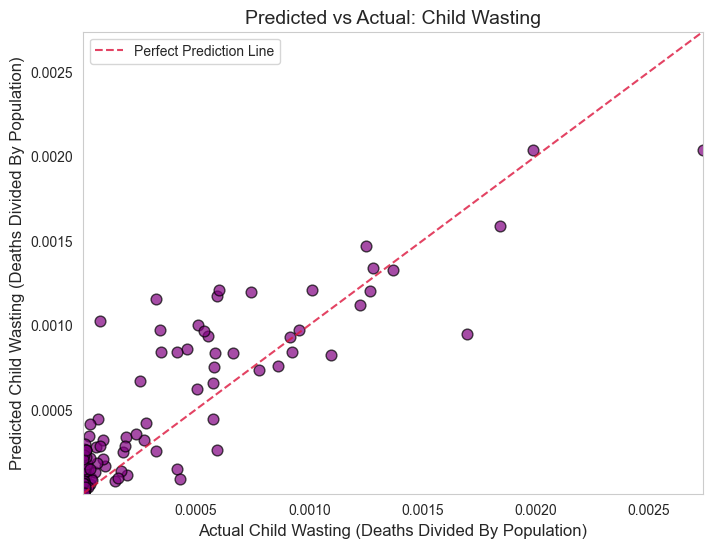

In [65]:
# Create Scatterplot comparing actual and predicted values.
plt.figure(figsize = (8, 6))

# Create scattered points.
plt.scatter(y_test, y_test_pred, color = 'purple', edgecolor = 'black', alpha = 0.7, s = 60)

# Add line that shows perfect predictions.
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
    '--', color = 'crimson', alpha = 0.8, label = 'Perfect Prediction Line')

# Set title and label axes.
plt.xlabel("Actual Child Wasting (Deaths Divided By Population)", fontsize = 12)
plt.ylabel("Predicted Child Wasting (Deaths Divided By Population)", fontsize = 12)
plt.title("Predicted vs Actual: Child Wasting", fontsize = 14)

# Set legend, grid, and limits.
plt.legend()
plt.grid()
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())

# Display scatterplot.
plt.show()

Before looking at how effective our model is, we have to compare it to the baseline model that predicts the mean. This model showed a testing R^2 score of -.2112 and a test RMSE of .0006. Our new model showed a training R^2 score of .8876, a testing R^2 score of .7116, a test RMSE of .0003, a 5-fold CV R^2 score of .3147, and a RepeatedKFold R^2 mean score of .7711. When looking at the two RMSE results, we can see that the predictive accuracy of our model is significantly better, as the RMSE is half of the baseline model. The difference between the testing and training R^2 shows that the model may be slightly overfitted, but not enough to warrant major concern, as the difference isn’t large. More specifically, the testing R^2 score tells us that our model can predict about 71% of the variation in the data from 2009, showing that this model is good for generalization. This is clear with the visual comparing the actual child-wasting proportions from 2009 to the predicted ones. The difference between the predicted versus actual rates shows our model gets fairly close to the actual values. The lower 5-fold cross-validation score suggests that the model suffers from some instability. However, the RepeatedKFold R^2 mean being significantly higher implies that the model is far more stable than the previous test led. 

This model does, however, suffer from some limitations. Ignoring the slight overfit because the data is scaled and the outliers are removed, the model may have a more difficult time looking at real-world data that does not scale or may have more outliers. As trends in nutrition continue to change, it is not unlikely that many of the rates that were once seen as outliers become more normalized. It is also important to note the period from when the data in this model was used. The data from this time may be harder to extrapolate to current data, as it has been a while since the original figures were taken. But, this still gives us a helpful insight into dietary death rates and child wasting rates around the world and proves that child wasting rates from 2009 can be predicted using dietary risk factor data from 1990 to 2008.

## Conclusion
This project explored two research questions: whether environmental-caused death counts from 1990 to 2009 could predict a country's GDP, and whether diet-related death counts from 1990 to 2008 could predict child wasting rates in 2009. To answer these, we used a range of regression models, transformations, and feature engineering techniques, and consistently evaluated model performance using Repeated K-Fold Cross-Validation to ensure stability across different data splits. For predicting GDP, a tuned XGBoost Regressor with log-transformed GDP performed the best, achieving a RKF CV R² of 0.9416. SHAP analysis revealed that *Household air pollution from solid fuels* and *Unsafe water source* were the most influential predictors. For predicting child wasting rates, a Random Forest model with feature selection, scaling, and outlier removal performed best, achieving a RKF CV R² of 0.7711. These findings support the idea that long-term health risks have measurable, predictive relationships with future economic and public health outcomes, affirmatively answering both research questions.

Even though the models performed well, there are still important limitations. Since we trained the models on historical data from 1990 to 2009, they might not predict future patterns well if global health risks, technology, or economies change. We also did not include important factors like political stability, education, or healthcare access, which could influenc*e G*DP and child health too. While SHAP values gave insights into which features mattered most, models like XGBoost are still complicated and harder to turn into direct policy actions. Another limitation is that the models might not work well if useinon countries with very different conditions from the training data. Overall, our models show strong patterns but more evidence would be needed to prove direct cause-and-effect relationships.

Future research could expand by using more detailed data that includes education, healthcare, government stability, and similar factors. Researchers could also track changes in risk factors over time to better understand how they influence outcomes. Studies that use natural experiments or other methods could help figure out whether improving public health risks would actually lead to higher GDP or lower child wasting. Open questions remain about whether these health factors still matter as much today as they did during the 1990–2009 period. Even with these limits, our work shows that public health risks are strong indicators of future national outcomes, and investing in basic health improvements could bring long-term benefits for both people and economies.


## References


- Agu, S. C., F. U. Onu, U. K. Ezemagu, and D. Oden. “Predicting Gross Domestic Product from Macroeconomic Indicators.” *Intelligent Systems with Applications*, vol. 14, 2022, article 200082. [ScienceDirect](https://doi.org/10.1016/j.iswa.2022.200082).

- ChartsBin. “Daily Calorie Intake per Capita.” 2010. [chartsbin.com/view/1150](https://chartsbin.com/view/1150). Accessed 28 Apr. 2025.

- Ergün, Serap. *Explaining XGBoost Predictions with SHAP Value: A Comprehensive Guide to Interpreting Decision Tree-Based Models.* Vilnius Tech, 14 Mar. 2023. [ResearchGate](https://www.researchgate.net/publication/369962623_EXPLAINING_XGBOOST_PREDICTIONS_WITH_SHAP_VALUE_A_COMPREHENSIVE_GUIDE_TO_INTERPRETING_DECISION_TREE-BASED_MODELS). Accessed 28 Apr. 2025.

- Fatima, Sana, et al. “XGBoost and Random Forest Algorithms: An In-Depth Analysis.” *Pakistan Journal of Scientific Research*, 30 June 2023. [ResearchGate](https://www.researchgate.net/publication/377135877_XGBoost_and_Random_Forest_Algorithms_An_in_Depth_Analysis). Accessed 28 Apr. 2025.

- Hayes, Tara O’Neill, and Rakeb Asres. “The Economic Costs of Poor Nutrition.” *American Action Forum*, 9 Mar. 2022. [americanactionforum.org](https://americanactionforum.org/research/the-economic-costs-of-poor-nutrition/). Accessed 28 Apr. 2025.

- Kuhn, Max, and Kjell Johnson. *Applied Predictive Modeling.* 2nd ed., Springer, 2023. [SpringerLink](https://link.springer.com/book/10.1007/978-1-4614-6849-3).

- Mathers, Colin D., et al. “Global and Regional Causes of Death.” *British Medical Bulletin*, vol. 92, no. 1, 22 Sept. 2009, pp. 7–32. [Oxford Academic](https://doi.org/10.1093/bmb/ldp028).

- Our World in Data. “Population.” *Our World in Data*, 2023. [ourworldindata.org/grapher/population](https://ourworldindata.org/grapher/population). Accessed 21 Apr. 2025.

- Popkin, Barry M., et al. “Trends in Diet, Nutritional Status, and Diet-Related Noncommunicable Diseases in China and India: The Economic Costs of the Nutrition Transition.” *Nutrition Reviews*, vol. 59, no. 12, 27 Apr. 2001, pp. 379–390. [doi:10.1111/j.1753-4887.2001.tb06967.x](https://doi.org/10.1111/j.1753-4887.2001.tb06967.x).

- Varpit94. “Worldwide Deaths by Country and Risk Factors.” *Kaggle*, 2021. [kaggle.com/datasets/varpit94/worldwide-deaths-by-risk-factors](https://www.kaggle.com/datasets/varpit94/worldwide-deaths-by-risk-factors). Accessed 28 Apr. 2025.

- World Bank. “GDP by Country in Current US$, 1988-2021 | WITS Data.” *World Integrated Trade Solution.* [wits.worldbank.org](https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/ltst/endyear/ltst/indicator/NY-GDP-MKTP-CD). Accessed 28 Apr. 2025.
r. 2025.

